In [1]:
import numpy as np
np.random.seed(1)

import dask.dataframe as dd
import pandas as pd

import wget
import zipfile
import os

import plotly.io as pio
pio.templates.default = "plotly_white" # Set plotly theme

if not os.path.isfile("rawinventor.tsv"):
    wget.download("https://s3.amazonaws.com/data.patentsview.org/download/rawinventor.tsv.zip")
    with zipfile.ZipFile("rawinventor.tsv.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    os.remove("rawinventor.tsv.zip")

if not os.path.isfile("disambiguation.tsv"):
    rawinventor = pd.read_csv("rawinventor.tsv", sep="\t")
    rawinventor["mention-id"] = "US" + rawinventor.patent_id.astype(str) + "-" + rawinventor.sequence.astype(str)
    rawinventor[["mention-id", "inventor_id"]].to_csv("disambiguation.tsv", sep="\t", index=False)
    del(rawinventor)

In [2]:
current = dd.read_csv("disambiguation.tsv", sep="\t")

In [3]:
data = current.compute()
reference = data.set_index("mention-id").inventor_id

In [4]:
prediction = reference.copy()
k = 2000000

I = np.random.choice(prediction.index, size=k, replace=False)
for i in I:
    j = np.random.choice(data.index, size=1)[0]
    prediction[i] = prediction[j]

In [5]:
from pv_evaluation.metrics import pairwise_precision_recall, pairwise_precision

pairwise_precision_recall(prediction, reference)

(0.8013926790503834, 0.806303156889863)

In [6]:
from pv_evaluation.estimators import pairwise_precision_estimator

def sample_clusters(series, k=200):
    clusters = np.random.choice(series.values, size=k, replace=True)
    return series[series.isin(clusters)]

n = 200
precision_values = np.zeros(n)
est_precision_values = np.zeros(n)
for i in range(n):
    benchmark = sample_clusters(reference)
    data = pd.concat({"prediction":prediction, "reference":benchmark}, axis=1, join="inner")
    precision_values[i] = (
        pairwise_precision(data.prediction, data.reference)
    )
    est_precision_values[i] = (
        pairwise_precision_estimator(prediction, benchmark, sampling_type="cluster", weights="cluster_size")
    )

In [12]:
np.mean(est_precision_values)

1.01934291801613

<AxesSubplot:ylabel='Count'>

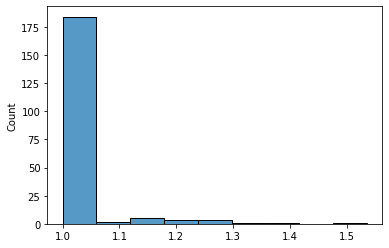

In [13]:
import seaborn as sns

sns.histplot(est_precision_values)

In [14]:
arr = est_precision_values
arr[arr >= 1] = 1
np.mean(arr)

1.0